In [1]:
%matplotlib inline
!pip install thop

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from thop import profile
from torchsummary import summary


# training a model first

In [123]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

NUM_RUNS = 3
EPOCHS = 10

In [124]:
# m = nn.Conv2d(1, 1, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))

In [125]:
def find_res_params_dilated(N1, C1, P1, S1):
  '''
    Keeping the number of parameters the same
    Approach III in the paper
  '''
  # N1=20 # orig image size

  # # layer 1
  # C1=3 # filter size old
  # K1=20  # num filters old
  # P1=0 # padding old
  # S1=1 # stride old

  # layer 2
  # B1=2 # filter size old
  # K3=10 # num filters old	
  # Q1=0 # padding old
  # R1=1 # stride old

  num_solutions = 0 
  Solutions = []

  for N2 in np.arange(N1+1,29): # new img resolution
    for P2 in np.arange(4): # new padding size in layer 1
      for S2 in np.arange(1,3): # new stride in layer 1
        for D2 in np.arange(2,4): # new dilation in layer 1      
          # import pdb; pdb.set_trace()
          M2 = int((N2 - D2*(C1-1) - 1 + 2*P2)  / S2  + 1)
          M1 = int((N1 - C1 + 2*P1)  / S1 + 1)

          if M2 == M1: 
            num_solutions += 1
            Solutions.append({'im_res_orig':N1, 'im_res_new':N2, 'layer1_old':[C1, P1, S1], 'layer1':[C1, P2, S2, D2]})

  # print(f'num solutions: {num_solutions}')
  return Solutions

In [126]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img


class NetTest(nn.Module):
    def __init__(self, im_res=28, conv1_size=3, conv2_size=3, pool1_size=2, pool2_size=2, num_conv1=10, num_conv2=10, stride_1=1, stride_2=1, padd_1=0, padd_2=0, num_hid=50, dilation_1=1):
        super(NetTest, self).__init__()
        # import pdb; pdb.set_trace()
        self.conv1 = nn.Conv2d(1, num_conv1, kernel_size=conv1_size, stride=stride_1, padding=padd_1, dilation=dilation_1, bias=False)
        self.res_conv1 = int((im_res - dilation_1*(conv1_size - 1) - 1 + 2*padd_1) / stride_1 + 1)
        self.res_pool1 = int((self.res_conv1 - pool1_size + 2*0) / pool1_size + 1)                

        self.conv2 = nn.Conv2d(num_conv1, num_conv2, kernel_size=conv2_size, stride=stride_2, padding=padd_2, bias=False)
        
        self.res_conv2 = int((self.res_pool1 - conv2_size + 2*padd_2) / stride_2 + 1 )       
        self.res_pool2 = int((self.res_conv2 - pool2_size + 2*0) / pool2_size + 1)               
        
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear((self.res_pool2**2)*num_conv2, num_hid, bias=False)        
        self.fc2 = nn.Linear(num_hid, 10, bias=False)
        self.pool1_size = pool1_size
        self.pool2_size = pool2_size
        self.num_conv2 = num_conv2
        self.im_res = im_res


        
    def forward(self, x):
        # import pdb; pdb.set_trace()

        tmp1 = F.relu(F.max_pool2d(self.conv1(x), self.pool1_size))
        tmp = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(tmp1)), self.pool2_size))
        # x = F.avg_pool2d(tmp, kernel_size=tmp.shape[-1])
        # x = x[:,:,0,0]

        x = tmp.view(-1, (self.res_pool2**2)*self.num_conv2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x   ### SUPER IMPORTANT ***************************** works with cross entropy loss loss now

device = 'cuda'


In [127]:
# c = 6
# p = 3
# s = 2
# assert 20 == (28 - c + 2*p) / s + 1, False
# 19 = 22 + 2*6 
# import cv2


In [128]:
def train_model(model):

  # EPOCHS = 10
  losses = []

  optimizer = optim.Adadelta(model.parameters())

  model.train()
  for epoch in range(EPOCHS):
      for batch_idx, (data, target) in enumerate(train_loader):
          
          data, target = data.to(device), target.to(device)        
          optimizer.zero_grad()
          y_pred = model(data) 

          # import pdb; pdb.set_trace()
          loss = F.cross_entropy(y_pred, target)
          losses.append(loss.cpu().data)

          loss.backward()
          optimizer.step()
          
          # Display
          if batch_idx % 100 == 1:
              print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch+1,
                  EPOCHS,
                  batch_idx * len(data), 
                  len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), 
                  loss.cpu().data), 
                  end='')

  # Eval
  # model.eval()
  # Eval
  model.eval()
  correct = total = 0
  for idx, (images, labels) in enumerate(test_loader):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      _, pre = torch.max(outputs.data, 1)

      total += len(labels)
      correct += (pre == labels).sum()

  accuracy = float(correct) / total
  print('Test Accuracy: %f %%' % accuracy)
  # return acc


  # import pdb; pdb.set_trace()
  # evaluate_x = test_loader.dataset.test_data.type_as(torch.FloatTensor()).to(device)
  # evaluate_y = test_loader.dataset.test_labels.to(device)

  # output = model(evaluate_x[:,None,...])
  # pred = output.data.max(1)[1]
  # d = pred.eq(evaluate_y.data).cpu()
  # accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
  
  print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
      epoch+1,
      EPOCHS,
      len(train_loader.dataset), 
      len(train_loader.dataset),
      100. * batch_idx / len(train_loader), 
      loss.cpu().data,
      accuracy*100,
      end=''))
  

  return accuracy

In [129]:
# sol_3

In [130]:
def evaluate_orig_model(sol):

  # run the original model for a couple of times
  # sol = sol_3[0]
  sol['orig_solutions'] = []

  im_res = sol['im_res_orig']
  cv1_size = int(sol['layer1_old'][0])
  pd1 = sol['layer1_old'][1]
  st1 = sol['layer1_old'][2]

  global train_loader
  global test_loader
  
  train_loader = torch.utils.data.DataLoader(
      datasets.FashionMNIST('../data', train=True, download=True, transform=transforms.Compose([
              transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)

  test_loader = torch.utils.data.DataLoader(
      datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
              transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)

  # for run_no in range(1):
  try:
      # print(f'----  im_res={im_res_new}, conv1_size={cv1_size}, conv2_size={cv2_size}')
      # import pdb; pdb.set_trace()
    accs = []
    for i in range(NUM_RUNS):
      model = NetTest(im_res=im_res, conv1_size=cv1_size, padd_1=pd1, stride_1=st1).to(device)
      if i==0:
        macs, params = profile(model, inputs=(torch.randn(1, 1, im_res, im_res).to(device), ))
      accs.append(train_model(model))
    
    sol['orig_solutions'].append((macs, params, np.mean(accs)))
    # accuracies.append((sol, macs, params, acc))
    # print(accuracies[-1])
    print(sol, '\n')

  except:
    print('\n Model invalid')


  return #sol


In [131]:
def evaluate_new_model(sols):
  # running the solutions; one by one; three each
  # for run_no

  for sol in sols:
        im_res = sol['im_res_new']
        cv1_size = int(sol['layer1'][0])
        pd1 = sol['layer1'][1]
        st1 = sol['layer1'][2]
        dl1 = sol['layer1'][3]


        sol['new_solutions'] = []

        global train_loader
        global test_loader

        train_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST('../data', train=True, download=True, transform=transforms.Compose([
                    transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)

        test_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
                    transforms.ToTensor(),transforms.Resize((im_res, im_res)),])), batch_size=100, shuffle=True)


        # for run_no in range(1):
        try:
          # print(f'----  im_res={im_res_new}, conv1_size={cv1_size}, conv2_size={cv2_size}')
          
          accs = []
          for i in range(NUM_RUNS):
            model = NetTest(im_res=im_res, conv1_size=cv1_size, padd_1=pd1, stride_1=st1, dilation_1=dl1).to(device)
            if i==0:
              macs, params = profile(model, inputs=(torch.randn(1, 1, im_res, im_res).to(device), ))
            accs.append(train_model(model))
          
          # which_model = 'new_res' if a else 'orig_res'
          # sol[which_model] = (macs, params, acc)
          sol['new_solutions'].append((macs, params, np.mean(accs)))
          # accuracies.append((sol, macs, params, acc))
          # print(accuracies[-1])
          print(sol, '\n')

        except:
          print('\n Model invalid')

  
  return #sols

In [132]:
# np.arange(3,8,2)

In [ ]:
import random 
all_res = {}

for N1 in [16]:#12,16,20,24]:
  all_solutions = []
  for C1 in np.arange(3,5,2): # filter size layer 1 
    for P1 in np.arange(3): # padding layer 1
      for S1 in np.arange(1,3): # stride layer 1    
          xx = find_res_params_dilated(N1, C1, P1, S1)
          if xx:
            all_solutions.append(xx)
  
  results = []
  random.shuffle(all_solutions)
  all_solutions.sort(key=len, reverse=True)
  all_solutions = all_solutions[:10]
  for idx, sol_3 in enumerate(all_solutions):
    print(f'\n --------------------- solution no {idx} -------------------- \n')

    if len(sol_3) > 4:
      sol_3 = sol_3[-4:]

    evaluate_orig_model(sol_3[0])
    if not sol_3[0]['orig_solutions']:
      break

    evaluate_new_model(sol_3)
    xx = (sol_3[0]['orig_solutions'][0], [sol['new_solutions'][0][-1] for sol in sol_3 if sol['new_solutions']])

    results.append(xx)

  all_res[N1] = results          
print(len(all_solutions))


 --------------------- solution no 0 -------------------- 

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.dropout.Dropout2d'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.NetTest'>. Treat it as zero Macs and zero Params.
 Train Epoch: 1/10 [40100/60000 (67%)]	Loss: 1.424414

In [114]:
# all_solutions[0]

In [135]:
# ([len(x) for x in all_solutions])
# sol_3
# 
# len(all_solutions)



all_res[N1]

[((18100.0, 1990.0, 0.7095666666666668),
  [0.6990333333333334, 0.7078333333333333, 0.7146, 0.7155666666666667]),
 ((29860.0, 3490.0, 0.7931333333333334),
  [0.7943666666666668, 0.7947666666666667, 0.7878, 0.7972666666666667])]

In [ ]:
all_solutions[2]

[{'im_res_new': 27,
  'im_res_orig': 24,
  'layer1': [3.0, 10, 2, 9],
  'layer1_old': [3, 10, 1, 0],
  'layer2': [3.0, 15, 1, 0],
  'layer2_old': [3, 15, 1, 0]},
 {'im_res_new': 27,
  'im_res_orig': 24,
  'layer1': [3.0, 10, 2, 9],
  'layer1_old': [3, 10, 1, 0],
  'layer2': [3.0, 15, 2, 9],
  'layer2_old': [3, 15, 1, 0]}]

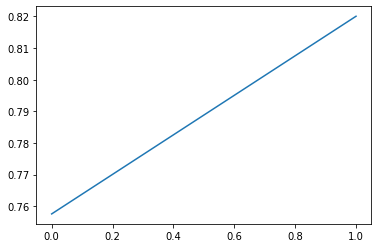

In [ ]:
for k in all_res.keys():
  means = np.mean(np.array([(x[-1],np.max(y)) for x,y in all_res[k]]), axis=0)
  # stds = np.std(np.array([(x[0][-1],np.max(y)) for x,y in all_res[k] ]), axis=0)
  plt.plot(means)

In [ ]:
means

array([0.75759   , 0.82007667])

In [ ]:
for k in all_res.keys():
  means = np.mean(np.array([(x[0][-1],y) for x,y in all_res[k] ]), axis=0)
  stds = np.std(np.array([(x[0][-1],y) for x,y in all_res[k] ]), axis=0)
  plt.plot(means)
